<a href="https://colab.research.google.com/github/abs-git/GNN/blob/main/tabular2graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from IPython.display import clear_output 
torch_version = torch.__version__
print("Torch version: ", torch_version)
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

# Homogeneous dataset

- The dataset contains only one node and edge type

In [ ]:
# FIFA 21 Rating dataset
import pandas as pd

!wget -q https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_player.csv
!wget -q https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_player_skill.csv
!wget -q https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_team.csv

# data load
player_df = pd.read_csv('tbl_player.csv')
skill_df = pd.read_csv('tbl_player_skill.csv')
team_df = pd.read_csv('tbl_team.csv')

In [ ]:
print(player_df.columns)
print()
print(skill_df.columns)
print()
print(team_df.columns)

Index(['int_player_id', 'str_player_name', 'str_positions', 'dt_date_of_birth',
       'int_height', 'int_weight', 'int_overall_rating',
       'int_potential_rating', 'str_best_position', 'int_best_overall_rating',
       'int_value', 'int_wage', 'str_player_image_url', 'int_team_id',
       'str_nationality'],
      dtype='object')

Index(['int_skill_id', 'int_player_id', 'int_dribbling', 'int_curve',
       'int_fk_accuracy', 'int_long_passing', 'int_ball_control'],
      dtype='object')

Index(['int_team_id', 'str_team_name', 'str_league', 'int_overall',
       'int_attack', 'int_midfield', 'int_defence',
       'int_international_prestige', 'int_domestic_prestige',
       'int_transfer_budget'],
      dtype='object')


In [ ]:
# features extract
player_df = player_df[['int_player_id', 'str_player_name', 'str_positions', 'int_overall_rating', 'int_team_id']]
skill_df = skill_df[['int_player_id', 'int_long_passing', 'int_ball_control', 'int_dribbling']]
team_df = team_df[['int_team_id', 'str_team_name', 'int_overall']]


# merge table
player_df = player_df.merge(skill_df, on = 'int_player_id')
player_df = player_df.merge(team_df, on = 'int_team_id')

player_df = player_df.sort_values(by = 'int_overall_rating', ascending=False)

player_df.head()

,int_player_id,str_player_name,str_positions,int_overall_rating,int_team_id,int_long_passing,int_ball_control,int_dribbling,str_team_name,int_overall
0,1,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,5.0,91,96,96,FC Barcelona,84
33,2,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",92,6.0,77,92,88,Juventus,83
57,3,Jan Oblak,GK,91,8.0,40,30,12,Atlético Madrid,83
121,5,Neymar da Silva Santos Júnior,"LW, CAM",91,7.0,81,95,95,Paris Saint-Germain,83
89,4,Kevin De Bruyne,"CAM, CM",91,2.0,93,92,88,Manchester City,85


In [ ]:
player_df['int_player_id'].value_counts()

1        1
12035    1
12031    1
12730    1
12603    1
        ..
6047     1
5801     1
6017     1
5855     1
19002    1
Name: int_player_id, Length: 18767, dtype: int64

In [ ]:
# player가 새로운 팀에서의 rating을 예측한다.

# Node : player
# Edge : link the same team player (player-player)
# Node feature : position, skills..
# Label : overall rating (Node-level prediction)


In [ ]:
# Node extraction

sorted_df = player_df.sort_values(by = 'int_player_id')

node_feats = sorted_df[['str_positions', 'int_long_passing', 'int_ball_control', 'int_dribbling']]

def get_main_position(str_positions):
  main_position = str_positions.split(',')[0]
  return main_position

node_feats['main_position'] = node_feats.apply(lambda x : get_main_position(x['str_positions']), axis = 1)

# positions one-hot encoding
node_feats = pd.concat([node_feats, pd.get_dummies(node_feats['main_position'])], axis = 1, join='inner')
node_feats.drop(['str_positions', 'main_position'], axis=1, inplace = True)

node_feats.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,int_long_passing,int_ball_control,int_dribbling,CAM,CB,CDM,CF,CM,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST
0,91,96,96,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
33,77,92,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
57,40,30,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
89,93,92,88,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
121,81,95,95,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Label extraction

sorted_df = player_df.sort_values(by='int_player_id')

labels = sorted_df[['int_overall']]
labels.head()

,int_overall
0,84
33,83
57,83
89,85
121,83


In [ ]:
# edge extraction

player_df['int_player_id'] = player_df.reset_index().index    # id init

In [ ]:
import itertools
import numpy as np

teams = player_df['str_team_name'].unique()
edge_index = np.array([], dtype = np.int32)
# print(edges.shape)
edge_index = edges.reshape((0,2))
# print(edges.shape)

for team in teams:
  team_df = player_df[player_df.str_team_name == team]
  players = team_df['int_player_id'].values

  permutations = list(itertools.combinations(players, 2))
  # print(permutations)

  edges_source = [edge[0] for edge in permutations]
  edges_target = [edge[1] for edge in permutations]
  
  # print(edges_source)
  # print(edges_target)

  team_edges = np.column_stack([edges_source, edges_target])
  # print(team_edges)

  edge_index = np.vstack([edge_index, team_edges])

print(edge_index)

edge_index = edge_index.transpose()
edge_index

[[    0     7]
 [    0    32]
 [    0    45]
 ...
 [18704 18719]
 [18704 18751]
 [18719 18751]]


array([[    0,     0,     0, ..., 18704, 18704, 18719],
       [    7,    32,    45, ..., 18719, 18751, 18751]])

In [ ]:
from torch_geometric.data import Data

data = Data(x = node_feats.to_numpy(),
            edge_index = labels.to_numpy(),
            y = edge_index.transpose())

data

Data(x=[18767, 18], edge_index=[18767, 1], y=[251934, 2])

# Heterogeneous

- The dataset contains least two node or edge types

In [ ]:
# Anime Recommende Dataset
import pandas as pd

!wget -q https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/anime.csv
!wget -q https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/rating.csv

anime_df = pd.read_csv('anime.csv')
rating_df = pd.read_csv('rating.csv')

print(anime_df.columns)
print(rating_df.columns)

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')
Index(['user_id', 'anime_id', 'rating'], dtype='object')


In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
# Node : User, Anime (two node types with different features)
# Edge : the rating between user and anime
# Node features : creating...
# label : rating for a anime -> (link prediction regression)


In [ ]:

sorted_df = anime_df.sort_values(by='anime_id').set_index('anime_id')
sorted_df = sorted_df.reset_index(drop = False)

anime_id_mapping = sorted_df['anime_id']

node_feats = sorted_df[['type', 'genre', 'episodes']]

genres = node_feats["genre"].str.split(",", expand=True)
node_feats['main_genre'] = genres[0]


# genre one-hot encoding
anime_node_feats = pd.concat([node_feats, pd.get_dummies(node_feats['main_genre'])], axis=1, join='inner')
anime_node_feats = pd.concat([anime_node_feats, pd.get_dummies(anime_node_feats['type'])], axis=1, join='inner')

anime_node_feats.drop(['genre', 'main_genre'], axis=1, inplace=True)

anime_node_feats.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,type,episodes,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Supernatural,Thriller,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,TV
0,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Movie,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,TV,52,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
node_feats = anime_node_feats.to_numpy()

In [ ]:
# user node features

mean_rating = rating_df.groupby('user_id')['rating'].mean().rename('mean')
num_rating = rating_df.groupby('user_id')['rating'].count().rename('count')
user_node_features = pd.concat([mean_rating, num_rating], axis = 1)

user_node_features = user_node_features.reset_index(drop=False)
user_id_mapping = user_node_features['user_id']

user_node_features = user_node_features[['mean', 'count']]

user_node_features.head()

,mean,count
0,-0.712418,153
1,2.666667,3
2,7.382979,94
3,-1.000000,52
4,4.263383,467


In [ ]:
x = user_node_features.to_numpy()

x.shape

(73515, 2)

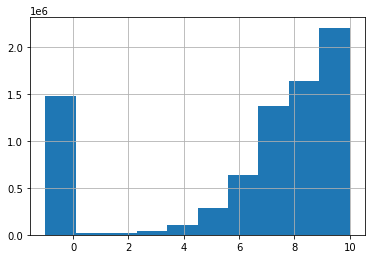

In [ ]:
# labels

rating_df['rating'].hist()

In [ ]:
print(rating_df['anime_id'].unique())
print(anime_df['anime_id'].sort_values().unique())

print(set(rating_df['anime_id'].unique()) - set(anime_df['anime_id'].unique()))

rating_df = rating_df[~rating_df['anime_id'].isin([30913, 30924, 20261])]

[   20    24    79 ... 29481 34412 30738]
[    1     5     6 ... 34522 34525 34527]
{30913, 30924, 20261}


In [ ]:
labels = rating_df['rating']

labels.shape

(7813727,)

In [ ]:
y = labels.to_numpy()

In [ ]:
# edges extraction

# mapping the user_id and the anime_id

movie_map = anime_id_mapping.reset_index().set_index('anime_id').to_dict()
print(movie_map)
rating_df['anime_id'] = rating_df['anime_id'].map(movie_map['index']).astype(int)
print(rating_df)

user_map = user_id_mapping.reset_index().set_index('user_id').to_dict()
print(user_map)
rating_df['user_id'] = rating_df['user_id'].map(user_map['index']).astype(int)
print(rating_df)

rating_df.head()

{'index': {1: 0, 5: 1, 6: 2, 7: 3, 8: 4, 15: 5, 16: 6, 17: 7, 18: 8, 19: 9, 20: 10, 21: 11, 22: 12, 23: 13, 24: 14, 25: 15, 26: 16, 27: 17, 28: 18, 29: 19, 30: 20, 31: 21, 32: 22, 33: 23, 43: 24, 44: 25, 45: 26, 46: 27, 47: 28, 48: 29, 49: 30, 50: 31, 51: 32, 52: 33, 53: 34, 54: 35, 55: 36, 56: 37, 57: 38, 58: 39, 59: 40, 60: 41, 61: 42, 62: 43, 63: 44, 64: 45, 65: 46, 66: 47, 67: 48, 68: 49, 69: 50, 71: 51, 72: 52, 73: 53, 74: 54, 75: 55, 76: 56, 77: 57, 79: 58, 80: 59, 81: 60, 82: 61, 83: 62, 84: 63, 85: 64, 86: 65, 87: 66, 88: 67, 89: 68, 90: 69, 91: 70, 92: 71, 93: 72, 94: 73, 95: 74, 96: 75, 97: 76, 98: 77, 99: 78, 100: 79, 101: 80, 102: 81, 103: 82, 104: 83, 105: 84, 106: 85, 107: 86, 108: 87, 109: 88, 110: 89, 111: 90, 112: 91, 113: 92, 114: 93, 115: 94, 116: 95, 117: 96, 118: 97, 119: 98, 120: 99, 121: 100, 122: 101, 123: 102, 124: 103, 125: 104, 126: 105, 127: 106, 128: 107, 129: 108, 130: 109, 131: 110, 132: 111, 133: 112, 134: 113, 135: 114, 136: 115, 137: 116, 138: 117, 139

,user_id,anime_id,rating
0,0,10,-1
1,0,14,-1
2,0,58,-1
3,0,202,-1
4,0,217,-1


In [ ]:
edge_index = rating_df[['user_id', 'anime_id']].values
print(edge_index)

edge_index = edge_index.transpose()

edge_index

[[    0    10]
 [    0    14]
 [    0    58]
 ...
 [73513  8624]
 [73514   718]
 [73514  5226]]


array([[    0,     0,     0, ..., 73513, 73514, 73514],
       [   10,    14,    58, ...,  8624,   718,  5226]])

In [ ]:
# build the dataset

from torch_geometric.data import HeteroData

data = HeteroData()

data['user'].x = user_node_features
data['anime'].x = anime_node_feats

data['user', 'rating', 'anime'].edge_index = edge_index

data['user', 'anime'].y = y       # link prediction

data

# Temporal Graph dataset

In [2]:
# Trip history of bikers in NYC dataset

import pandas as pd

!wget -q http://s3.amazonaws.com/tripdata/201306-citibike-tripdata.zip
!unzip -o 201306-citibike-tripdata.zip

trips = pd.read_csv("201306-citibike-tripdata.csv")

Archive:  201306-citibike-tripdata.zip
  inflating: 201306-citibike-tripdata.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._201306-citibike-tripdata.csv  


In [3]:
print(trips.columns)
trips.head()

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [4]:
removal_cols = ['start station name', 'end station name']

trips.dropna(inplace = True)
trips.drop(removal_cols, axis = 1, inplace = True)

trips.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,40.742354,-73.989151,434.0,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,40.742354,-73.989151,434.0,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,40.735243,-73.987586,262.0,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,40.705693,-74.016777,310.0,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,285,40.734546,-73.990741,532.0,40.710451,-73.960876,15693,Subscriber,1991.0,1


In [5]:
# reassin the location IDs

locations = trips['start station id'].unique()
print(locations[:5])

new_ids = list(range(len(trips['start station id'].unique())))
print(new_ids[:5])

mapping = dict(zip(locations, new_ids))
print(mapping)

trips['start station id'] = trips['start station id'].map(mapping)
trips['end station id'] = trips['end station id'].map(mapping)

trips.head()

[ 444  475 2008  285  509]
[0, 1, 2, 3, 4]
{444: 0, 475: 1, 2008: 2, 285: 3, 509: 4, 265: 5, 404: 6, 423: 7, 241: 8, 527: 9, 309: 10, 494: 11, 380: 12, 305: 13, 480: 14, 453: 15, 223: 16, 476: 17, 312: 18, 482: 19, 439: 20, 531: 21, 358: 22, 83: 23, 271: 24, 445: 25, 477: 26, 293: 27, 493: 28, 473: 29, 489: 30, 517: 31, 2004: 32, 249: 33, 79: 34, 465: 35, 247: 36, 412: 37, 521: 38, 490: 39, 369: 40, 510: 41, 389: 42, 492: 43, 3019: 44, 236: 45, 357: 46, 303: 47, 470: 48, 354: 49, 300: 50, 233: 51, 504: 52, 143: 53, 441: 54, 244: 55, 2022: 56, 281: 57, 508: 58, 355: 59, 420: 60, 481: 61, 528: 62, 311: 63, 328: 64, 270: 65, 146: 66, 466: 67, 488: 68, 447: 69, 362: 70, 514: 71, 259: 72, 294: 73, 251: 74, 238: 75, 376: 76, 461: 77, 405: 78, 459: 79, 428: 80, 252: 81, 384: 82, 2009: 83, 239: 84, 278: 85, 479: 86, 168: 87, 151: 88, 393: 89, 518: 90, 324: 91, 516: 92, 442: 93, 478: 94, 326: 95, 82: 96, 348: 97, 460: 98, 350: 99, 150: 100, 308: 101, 323: 102, 336: 103, 469: 104, 523: 105, 349:

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,0,40.742354,-73.989151,299,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,0,40.742354,-73.989151,299,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,1,40.735243,-73.987586,187,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2,40.705693,-74.016777,257,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,3,40.734546,-73.990741,280,40.710451,-73.960876,15693,Subscriber,1991.0,1


In [6]:
# Node : locations
# Node Features : attributes about each location
# Edge : proximity between two locations
# Edge weights : connection
# Edge features : 
# labels : trip duration -> Link prediction task
# timesteps : 60 min


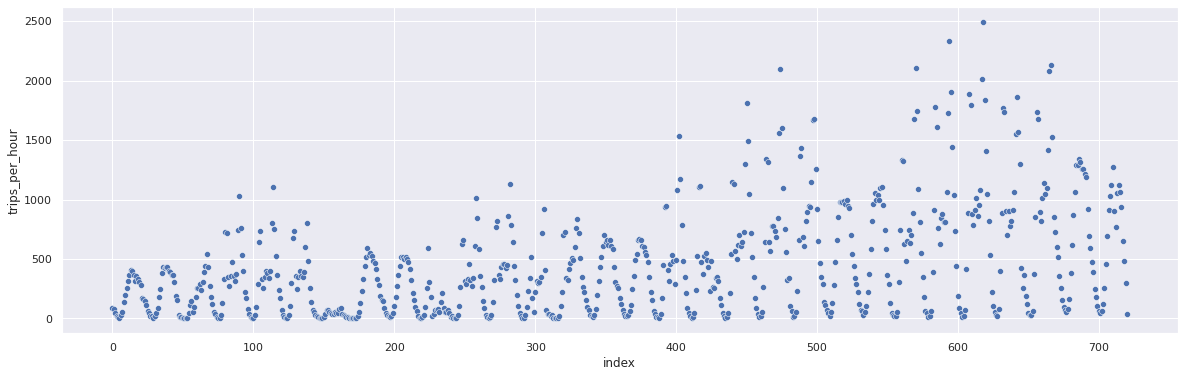

In [7]:
from datetime import datetime, timedelta
import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})

trips['starttime'] = pd.to_datetime(trips['starttime'], format = "%Y-%m-%d %H:%M:%S")
trips['stoptime'] = pd.to_datetime(trips['stoptime'], format = "%Y-%m-%d %H:%M:%S")

start_date = datetime.strptime("2013-06-01 00:00:01", '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime("2013-07-01 00:10:34", '%Y-%m-%d %H:%M:%S')
interval = timedelta(minutes=60)

bucket_elements = []
while start_date <= end_date:
  bucket_elements.append(trips[((start_date + interval) >= trips['stoptime'])
                        & (start_date <= trips['stoptime'])].shape[0])

  start_date += interval


sns.scatterplot(x = 'index', y = 'trips_per_hour', data = pd.DataFrame(bucket_elements, columns = ['trips_per_hour']).reset_index())

In [10]:
import numpy as np

outgoing_trips = trips.groupby('start station id').count()['bikeid'].values
incoming_trips = trips.groupby('end station id').count()['bikeid'].values

# Nomalize
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose()

print(node_features.shape)
node_features[:5]

(337, 2)


array([[0.76524844, 0.79829787],
       [0.39452544, 0.36964539],
       [0.16691461, 0.18751773],
       [0.92740256, 0.86297872],
       [0.6155906 , 0.62014184]])

In [12]:
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

subset = ['start station longitude', 'start station latitude', 'start station id']
all_starts = trips.drop_duplicates(subset = 'start station id', keep='first')[subset]

print(all_starts)

subset = ['end station longitude', 'end station latitude', 'end station id']
all_ends = trips.drop_duplicates(subset = 'end station id', keep='first')[subset]

distance_matrix = all_ends.merge(all_starts, how='cross')
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["start station latitude"], x["start station longitude"]), 
                                                          (x["end station latitude"], x["end station longitude"])).meters, axis=1)


distance_matrix.head()

        start station longitude  start station latitude  start station id
0                    -73.989151               40.742354                 0
3                    -73.987586               40.735243                 1
4                    -74.016777               40.705693                 2
6                    -73.990741               40.734546                 3
7                    -74.001971               40.745497                 4
...                         ...                     ...               ...
21082                -74.004607               40.712733               332
70833                -73.986536               40.755467               333
73284                -73.996224               40.717591               334
333097               -73.978462               40.748158               335
340963               -73.956431               40.690649               336

[337 rows x 3 columns]


,end station longitude,end station latitude,end station id,start station longitude,start station latitude,start station id,distance
0,-74.003664,40.743174,299,-73.989151,40.742354,0,1229.224446
1,-74.003664,40.743174,299,-73.987586,40.735243,1,1618.732623
2,-74.003664,40.743174,299,-74.016777,40.705693,2,4307.215223
3,-74.003664,40.743174,299,-73.990741,40.734546,3,1452.477060
4,-74.003664,40.743174,299,-74.001971,40.745497,4,294.928845


In [13]:
# cutoff

distance_matrix['edge'] = distance_matrix['distance'] < 500

distance_matrix

,end station longitude,end station latitude,end station id,start station longitude,start station latitude,start station id,distance,edge
0,-74.003664,40.743174,299,-73.989151,40.742354,0,1229.224446,False
1,-74.003664,40.743174,299,-73.987586,40.735243,1,1618.732623,False
2,-74.003664,40.743174,299,-74.016777,40.705693,2,4307.215223,False
3,-74.003664,40.743174,299,-73.990741,40.734546,3,1452.477060,False
4,-74.003664,40.743174,299,-74.001971,40.745497,4,294.928845,True
...,...,...,...,...,...,...,...,...
113564,-73.981632,40.752062,272,-74.004607,40.712733,332,4779.310004,False
113565,-73.981632,40.752062,272,-73.986536,40.755467,333,560.737588,False
113566,-73.981632,40.752062,272,-73.996224,40.717591,334,4021.571295,False
113567,-73.981632,40.752062,272,-73.978462,40.748158,335,509.579609,False


In [20]:
edge_index = distance_matrix[distance_matrix['edge'] == True][['start station id', 'end station id']].values
print(edge_index)
print()

edge_index = edge_index.transpose()
print(edge_index.shape)
print(edge_index)

[[  4 299]
 [  6 299]
 [ 15 299]
 ...
 [315 272]
 [317 272]
 [327 272]]

(2, 2725)
[[  4   6  15 ... 315 317 327]
 [299 299 299 ... 272 272 272]]


In [21]:
distance_feature = distance_matrix[distance_matrix['edge'] == True]['distance'].values

edge_type_feature = np.zeros_like(distance_feature)
trip_duration_feature = np.zeros_like(distance_feature)

print(edge_type_feature.shape)

static_edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()

static_edge_features

(2725,)


array([[294.92884499,   0.        ,   0.        ],
       [327.27388739,   0.        ,   0.        ],
       [419.30404213,   0.        ,   0.        ],
       ...,
       [379.44132958,   0.        ,   0.        ],
       [349.85678078,   0.        ,   0.        ],
       [332.80260533,   0.        ,   0.        ]])

In [23]:
# Labels

def extract_dynamic_edges(s):
  trip_indices = s[['start station id', 'end station id']].values
  trip_durations = s['tripduration']

  distance_feature = pd.DataFrame(trip_indices,
                                  columns = ['start station id', 'end station id']).merge(
                                      distance_matrix, on=['start station id', 'end station id'],
                                      how='left'
                                  )['distance'].values

  edge_type_feature = np.ones_like(distance_feature)
  trip_duration_feature = trip_durations
  edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()

  return edge_features, trip_indices.transpose()


In [24]:

start_date = datetime.strptime("2013-06-01 00:00:01", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2013-07-01 00:10:34", "%Y-%m-%d %H:%M:%S")
interval = timedelta(minutes=60)

xs = []
edge_indices = []
ys = []
y_indices = []
edge_features = []


while start_date <= end_date:
    # 0 - 60 min 
    current_snapshot = trips[((start_date + interval) >= trips["stoptime"])
                                  & (start_date <= trips["stoptime"])]
    # 60 - 120 min
    subsequent_snapshot = trips[((start_date + 2*interval) >= trips["stoptime"])
                                  & (start_date + interval <= trips["stoptime"])]
    # Average duplicate trips
    current_snapshot = current_snapshot.groupby(["start station id", "end station id"]).mean().reset_index()
    subsequent_snapshot = subsequent_snapshot.groupby(["start station id", "end station id"]).mean().reset_index()

    # Extract dynamic trip edges
    edge_feats, additional_edge_index = extract_dynamic_edges(current_snapshot)
    exteneded_edge_index = np.concatenate([edge_index, additional_edge_index], axis=1)
    extended_edge_feats = np.concatenate([edge_feats, static_edge_features], axis=0)

    # Labels
    y = subsequent_snapshot["tripduration"].values
    y_index = subsequent_snapshot[["start station id", "end station id"]].values

    # Append everything
    xs.append(node_features) # static
    edge_indices.append(exteneded_edge_index) # static + dynamic
    edge_features.append(extended_edge_feats) # static + dynamic
    ys.append(y) # dynamic
    y_indices.append(y_index.transpose()) # dynamic

    # Increment
    start_date += interval

In [29]:
index = 3

print('Node feature : {}'.format(xs[index].shape))
print('Edge index : {}'.format(edge_indices[index].shape))
print('Edge feature : {}'.format(edge_features[index].shape))
print('labels : {}'.format(ys[index].shape))
print('labels mask : {}'.format(y_indices[index].shape))


Node feature : (337, 2)
Edge index : (2, 2750)
Edge feature : (2750, 3)
labels : (11,)
labels mask : (2, 11)


In [ ]:
# create dataset

from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
dataset = DynamicGraphTemporalSignal(
            edge_indices, edge_features, xs, ys, y_indices=y_indices
        )
